# Dataset Description

Variable	Definition	Key

survival	Survival	0 = No, 1 = Yes
pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
sex	Sex	
Age	Age in years	
sibsp	# of siblings / spouses aboard the Titanic	
parch	# of parents / children aboard the Titanic	
ticket	Ticket number	
fare	Passenger fare	
cabin	Cabin number	
embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton
Variable Notes
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

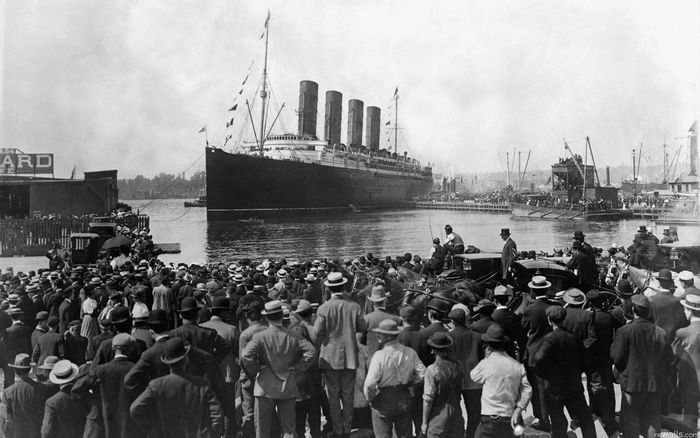

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd
import pandas_profiling as pp
import math
import random
import matplotlib.pyplot as plt
%matplotlib inline

# preprocessing
import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, learning_curve, ShuffleSplit
from sklearn.model_selection import cross_val_predict as cvp
from sklearn import metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score

# models
from sklearn.linear_model import LinearRegression, LogisticRegression, Perceptron, RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC, LinearSVC, SVR
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier 
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

        
traindf = pd.read_csv("../input/titanic/train.csv").set_index('PassengerId')
testdf = pd.read_csv("../input/titanic/test.csv").set_index('PassengerId')
submission = pd.read_csv("../input/titanic/gender_submission.csv")
traindf.head()
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [3]:
testdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


In [4]:
df = pd.concat([traindf, testdf], axis=0, sort=False)
df['Title'] = df.Name.str.split(',').str[1].str.split('.').str[0].str.strip()
df['Title'] = df.Name.str.split(',').str[1].str.split('.').str[0].str.strip()
df['IsWomanOrBoy'] = ((df.Title == 'Master') | (df.Sex == 'female'))
df['LastName'] = df.Name.str.split(',').str[0]


In [5]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,IsWomanOrBoy,LastName
PassengerId,,,,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,False,Braund
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,True,Cumings
3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,True,Heikkinen
4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,True,Futrelle
5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,False,Allen


# Data preprocessing

In [6]:
df['Title'] = df['Title'].replace('Ms','Miss')
df['Title'] = df['Title'].replace('Mlle','Miss')
df['Title'] = df['Title'].replace('Mme','Mrs')

# Embarked, Fare !
df['Embarked'] = df['Embarked'].fillna('S')
med_fare = df.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
df['Fare'] = df['Fare'].fillna(med_fare)

# Cabin, Deck, famous_cabin !
df['famous_cabin'] = df["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
df['Deck'] = df['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')
df.loc[(df['Deck'] == 'T'), 'Deck'] = 'A'

# Family_Size !
df['Family_Size'] = df['SibSp'] + df['Parch'] + 1

# Name_length !
df['Name_length'] = df['Name'].apply(len)

In [7]:
cols_to_drop = ['Name','Ticket','Cabin']   
df = df.drop(cols_to_drop, axis=1)

In [8]:
Y = df.Survived.loc[traindf.index].astype(int)
X_train, X_test = df.loc[traindf.index], df.loc[testdf.index]
X_test = X_test.drop(['Survived'], axis = 1)

In [9]:
# Determination categorical features
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
categorical_columns = []
features = X_train.columns.values.tolist()
for col in features:
    if X_train[col].dtype in numerics: continue
    categorical_columns.append(col)
categorical_columns

['Sex', 'Embarked', 'Title', 'IsWomanOrBoy', 'LastName', 'Deck']

In [10]:
# Encoding categorical features
for col in categorical_columns:
    if col in X_train.columns:
        le = LabelEncoder()
        le.fit(list(X_train[col].astype(str).values) + list(X_test[col].astype(str).values))
        X_train[col] = le.transform(list(X_train[col].astype(str).values))
        X_test[col] = le.transform(list(X_test[col].astype(str).values))

In [11]:
X_train = X_train.reset_index()
X_test = X_test.reset_index()
X_dropna_categor = X_train.dropna().astype(int)
Xtest_dropna_categor = X_test.dropna().astype(int)

In [12]:
# Surviving girls:
Sex_female_Survived = X_dropna_categor.loc[(X_dropna_categor.Sex == 0) & (X_dropna_categor.Survived == 1)]
# Dead girls:
Sex_female_NoSurvived = X_dropna_categor.loc[(X_dropna_categor.Sex == 0) & (X_dropna_categor.Survived == 0)]
# Surviving guys:
X_Sex_male_Survived = X_dropna_categor.loc[(X_dropna_categor.Sex == 1) & (X_dropna_categor.Survived == 1)] 
# Dead guys:
X_Sex_male_NoSurvived = X_dropna_categor.loc[(X_dropna_categor.Sex == 1) & (X_dropna_categor.Survived == 0)]

X_test_male = Xtest_dropna_categor.loc[Xtest_dropna_categor.Sex == 1]
X_test_female = Xtest_dropna_categor.loc[Xtest_dropna_categor.Sex == 0]

female_Survived_mean, female_NoSurvived_mean = Sex_female_Survived['Age'].mean(), Sex_female_NoSurvived['Age'].mean()
male_Survived_mean, male_NoSurvived_mean = X_Sex_male_Survived['Age'].mean(), X_Sex_male_NoSurvived['Age'].mean()

female_Survived_std, female_NoSurvived_std = Sex_female_Survived['Age'].std(), Sex_female_NoSurvived['Age'].std()
male_Survived_std, male_NoSurvived_std = X_Sex_male_Survived['Age'].std(), X_Sex_male_NoSurvived['Age'].std()

female_std, female_mean = X_test_female['Age'].std(), X_test_female['Age'].mean()
male_std, male_mean = X_test_male['Age'].std(), X_test_male['Age'].mean()

X_train['Survived'] = X_train['Survived'].astype(int)

In [13]:
# Confidence interval calculation function: 
def derf(sample, mean, std):
    age_shape = sample['Age'].shape[0] # sample size
    if age_shape > 0:
        standard_error_ofthe_mean = std / math.sqrt(age_shape)
        random_mean = round(random.uniform(mean-(1.96*standard_error_ofthe_mean), mean+(1.96*standard_error_ofthe_mean)), 2)
    else: random_mean = 0
    
    return random_mean

In [14]:
for i in X_train.loc[(X_train['Sex']==0) & (X_train['Survived']==1) & (X_train['Age'].isnull())].index:
    X_train.at[i, 'Age'] = derf(Sex_female_Survived, female_Survived_mean, female_Survived_std)

for h in X_train.loc[(X_train['Sex']==0) & (X_train['Survived']==0) & (X_train['Age'].isnull())].index:
    X_train.at[h, 'Age'] = derf(Sex_female_NoSurvived, female_NoSurvived_mean, female_NoSurvived_std)
    
for l in X_train.loc[(X_train['Sex']==1) & (X_train['Survived']==1) & (X_train['Age'].isnull())].index:
    X_train.at[l, 'Age'] = derf(X_Sex_male_Survived, male_Survived_mean, male_Survived_std)
    
for b in X_train.loc[(X_train['Sex']==1) & (X_train['Survived']==0) & (X_train['Age'].isnull())].index:
    X_train.at[b, 'Age'] = derf(X_Sex_male_NoSurvived, male_NoSurvived_mean, male_NoSurvived_std)
    
for p in X_test.loc[(X_test['Sex']==1) & (X_test['Age'].isnull())].index:
    X_test.at[p, 'Age'] = derf(X_test_male, male_mean, male_std)

for y in X_test.loc[(X_test['Sex']==0) & (X_test['Age'].isnull())].index:
    X_test.at[y, 'Age'] = derf(X_test_female, female_mean, female_std)

In [15]:
X_train

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,IsWomanOrBoy,LastName,famous_cabin,Deck,Family_Size,Name_length
0,1,0,3,1,22.00,1,0,7.2500,2,10,0,100,0,7,2,23
1,2,1,1,0,38.00,1,0,71.2833,0,11,1,182,1,2,2,51
2,3,1,3,0,26.00,0,0,7.9250,2,9,1,329,0,7,1,22
3,4,1,1,0,35.00,1,0,53.1000,2,11,1,267,1,2,2,44
4,5,0,3,1,35.00,0,0,8.0500,2,10,0,15,0,7,1,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,1,27.00,0,0,13.0000,2,12,0,535,0,7,1,21
887,888,1,1,0,19.00,0,0,30.0000,2,9,1,294,1,1,1,28
888,889,0,3,0,22.92,1,2,23.4500,2,9,1,383,0,7,4,40
889,890,1,1,1,26.00,0,0,30.0000,0,10,0,69,1,2,1,21


In [16]:
X_train = X_train.drop(['Survived'], axis = 1)

In [17]:
print(X_train.isnull().sum())
print(X_test.isnull().sum())

PassengerId     0
Pclass          0
Sex             0
Age             0
SibSp           0
Parch           0
Fare            0
Embarked        0
Title           0
IsWomanOrBoy    0
LastName        0
famous_cabin    0
Deck            0
Family_Size     0
Name_length     0
dtype: int64
PassengerId     0
Pclass          0
Sex             0
Age             0
SibSp           0
Parch           0
Fare            0
Embarked        0
Title           0
IsWomanOrBoy    0
LastName        0
famous_cabin    0
Deck            0
Family_Size     0
Name_length     0
dtype: int64


In [18]:
cv_n_split = 2
random_state = 0
test_train_split_part = 0.15
metrics_all = {1 : 'r2_score', 2: 'acc', 3 : 'rmse', 4 : 're'}
metrics_now = [1, 2, 3, 4] # you can only select some numbers of metrics from metrics_all

In [19]:
train0, test0 = X_train, X_test
target0 = Y

# Standartization
scaler = StandardScaler()
train0 = pd.DataFrame(scaler.fit_transform(train0), columns = train0.columns)
test0 = pd.DataFrame(scaler.transform(test0), columns = test0.columns)

# For boosting model
train0b = train0.copy()
test0b = test0.copy()
# Synthesis valid as "test" for selection models

trainb, testb, targetb, target_testb = train_test_split(train0b, target0, test_size=test_train_split_part, random_state=random_state)

In [20]:
# For models from Sklearn
# Normalization
scaler = MinMaxScaler()
train0 = pd.DataFrame(scaler.fit_transform(train0), columns = train0.columns)
test0 = pd.DataFrame(scaler.fit_transform(test0), columns = test0.columns)


In [21]:
# Synthesis valid as test for selection models
train, test, target, target_test = train_test_split(train0, target0, test_size=test_train_split_part, random_state=random_state)

In [22]:
# list of accuracy of all model - amount of metrics_now * 2 (train & test datasets)
num_models = 10
acc_train = []
acc_test = []
acc_all = np.empty((len(metrics_now)*2, 0)).tolist()
acc_all

[[], [], [], [], [], [], [], []]

In [23]:
acc_all_pred = np.empty((len(metrics_now), 0)).tolist()
acc_all_pred

[[], [], [], []]

In [24]:
# Splitting train data for model tuning with cross-validation
cv_train = ShuffleSplit(n_splits=cv_n_split, test_size=test_train_split_part, random_state=random_state)

# ML models

We will use 10 classification models and compare with them :
- Decision Tree Classifier
- GradientBoostingClassifier
- LGBMClassifier
- XGBClassifier
- ExtraTreesClassifier
- Linear SVC
- Gaussian Process Classification
- aggingClassifier
- Random Forest
- KNN


ML models based on the notebook https://www.kaggle.com/code/vbmokin/autoselection-from-20-classifier-models-l-curves

In [25]:
def acc_d(y_meas, y_pred):
    # Relative error between predicted y_pred and measured y_meas values
    return mean_absolute_error(y_meas, y_pred)*len(y_meas)/sum(abs(y_meas))

def acc_rmse(y_meas, y_pred):
    # RMSE between predicted y_pred and measured y_meas values
    return (mean_squared_error(y_meas, y_pred))**0.5

In [26]:
def acc_metrics_calc(num,model,train,test,target,target_test):
    # The models selection stage
    # Calculation of accuracy of model by different metrics
    global acc_all

    ytrain = model.predict(train).astype(int)
    ytest = model.predict(test).astype(int)
    print('target = ', target[:5].values)
    print('ytrain = ', ytrain[:5])
    print('target_test =', target_test[:5].values)
    print('ytest =', ytest[:5])

    num_acc = 0
    for x in metrics_now:
        if x == 1:
            #r2_score criterion
            acc_train = round(r2_score(target, ytrain) * 100, 2)
            acc_test = round(r2_score(target_test, ytest) * 100, 2)
        elif x == 2:
            #accuracy_score criterion
            acc_train = round(metrics.accuracy_score(target, ytrain) * 100, 2)
            acc_test = round(metrics.accuracy_score(target_test, ytest) * 100, 2)
        elif x == 3:
            #rmse criterion
            acc_train = round(acc_rmse(target, ytrain) * 100, 2)
            acc_test = round(acc_rmse(target_test, ytest) * 100, 2)
        elif x == 4:
            #relative error criterion
            acc_train = round(acc_d(target, ytrain) * 100, 2)
            acc_test = round(acc_d(target_test, ytest) * 100, 2)
        
        print('acc of', metrics_all[x], 'for train =', acc_train)
        print('acc of', metrics_all[x], 'for test =', acc_test)
        acc_all[num_acc].append(acc_train) #train
        acc_all[num_acc+1].append(acc_test) #test
        num_acc += 2

In [27]:
target_name = 'Survived'

In [28]:
def acc_metrics_calc_pred(num,model,name_model,train,test,target):
    # The prediction stage
    # Calculation of accuracy of model for all different metrics and creates of the main submission file for the best model (num=0)
    global acc_all_pred

    ytrain = model.predict(train).astype(int)
    ytest = model.predict(test).astype(int)

    print('**********')
    print(name_model)
    print('target = ', target[:15].values)
    print('ytrain = ', ytrain[:15])
    print('ytest =', ytest[:15])
    
    num_acc = 0
    for x in metrics_now:
        if x == 1:
            #r2_score criterion
            acc_train = round(r2_score(target, ytrain) * 100, 2)
        elif x == 2:
            #accuracy_score criterion
            acc_train = round(metrics.accuracy_score(target, ytrain) * 100, 2)
        elif x == 3:
            #rmse criterion
            acc_train = round(acc_rmse(target, ytrain) * 100, 2)
        elif x == 4:
            #relative error criterion
            acc_train = round(acc_d(target, ytrain) * 100, 2)

        print('acc of', metrics_all[x], 'for train =', acc_train)
        acc_all_pred[num_acc].append(acc_train) #train
        num_acc += 1
    
    # Save the submission file
    submission[target_name] = ytest
    submission.to_csv('submission_' + name_model + '.csv', index=False) 

In [29]:
# Thanks to https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py
def plot_learning_curve(estimator, title, X, y, cv=None, axes=None, ylim=None, 
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5), random_state=0):
    """
    Generate 2 plots: 
    - the test and training learning curve, 
    - the training samples vs fit times curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    
    random_state : random_state
    
    """
    fig, axes = plt.subplots(2, 1, figsize=(20, 10))
    
    if axes is None:
        _, axes = plt.subplots(1, 2, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    cv_train = ShuffleSplit(n_splits=cv_n_split, test_size=test_train_split_part, random_state=random_state)
    
    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator=estimator, X=X, y=y, cv=cv,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    plt.show()
    return

## 1- Decision Tree Classifier	

This model uses a **Decision Tree** as a predictive model which maps features (tree branches) to conclusions about the target value (tree leaves). Tree models where the target variable can take a finite set of values are called classification trees; in these tree structures, leaves represent class l
abels and branches represent conjunctions of features that lead to those class labels. Decision trees where the target variable can take continuous values (typically real numbers) are called regression trees. 
Reference Wikipedia.

In [30]:
# Decision Tree Classifier

decision_tree = DecisionTreeClassifier()
param_grid = {'min_samples_leaf': [i for i in range(2,10)]}
decision_tree_CV = GridSearchCV(decision_tree, param_grid=param_grid, cv=cv_train, verbose=False)
decision_tree_CV.fit(train, target)
print(decision_tree_CV.best_params_)
acc_metrics_calc(5,decision_tree_CV,train,test,target,target_test)

{'min_samples_leaf': 7}
target =  [0 0 0 0 0]
ytrain =  [0 0 0 0 0]
target_test = [0 0 0 1 1]
ytest = [0 0 0 1 0]
acc of r2_score for train = 52.86
acc of r2_score for test = 25.98
acc of acc for train = 88.9
acc of acc for test = 82.09
acc of rmse for train = 33.31
acc of rmse for test = 42.32
acc of re for train = 29.27
acc of re for test = 43.64


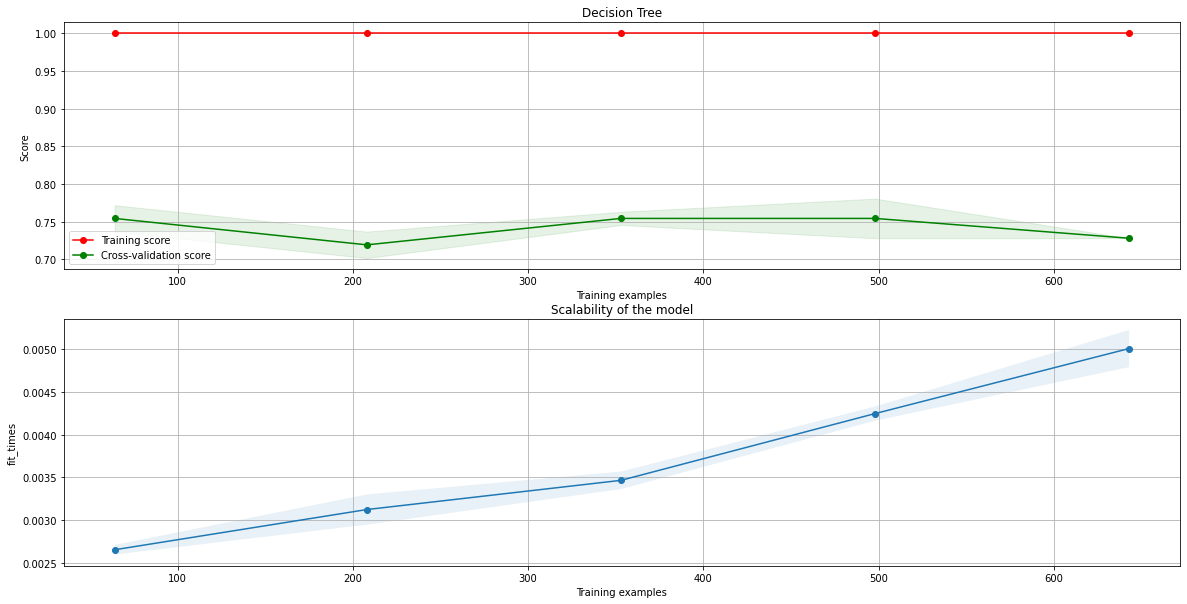

In [31]:
# Building learning curve of model
plot_learning_curve(decision_tree, "Decision Tree", train, target, cv=cv_train)

## 2- GradientBoostingClassifier	

**Gradient Boosting** builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage nclasses regression trees are fit on the negative gradient of the binomial or multinomial deviance loss function. Binary classification is a special case where only a single regression tree is induced. The features are always randomly permuted at each split. Therefore, the best found split may vary, even with the same training data and max_features=n_features, if the improvement of the criterion is identical for several splits enumerated during the search of the best split. To obtain a deterministic behaviour during fitting, random_state has to be fixed. 
Reference sklearn documentation.

In [32]:
# Gradient Boosting Classifier

gradient_boosting = GradientBoostingClassifier()
param_grid = {'learning_rate' : [0.001, 0.01, 0.1],
              'max_depth': [i for i in range(2,5)],
              'min_samples_leaf': [i for i in range(2,5)]}
gradient_boosting_CV = GridSearchCV(estimator=gradient_boosting, param_grid=param_grid, 
                                    cv=cv_train, verbose=False)
gradient_boosting_CV.fit(train, target)
print(gradient_boosting_CV.best_params_)
acc_metrics_calc(9,gradient_boosting_CV,train,test,target,target_test)

{'learning_rate': 0.01, 'max_depth': 4, 'min_samples_leaf': 3}
target =  [0 0 0 0 0]
ytrain =  [0 0 0 0 0]
target_test = [0 0 0 1 1]
ytest = [0 0 0 1 1]
acc of r2_score for train = 42.2
acc of r2_score for test = 32.15
acc of acc for train = 86.39
acc of acc for test = 83.58
acc of rmse for train = 36.89
acc of rmse for test = 40.52
acc of re for train = 35.89
acc of re for test = 40.0


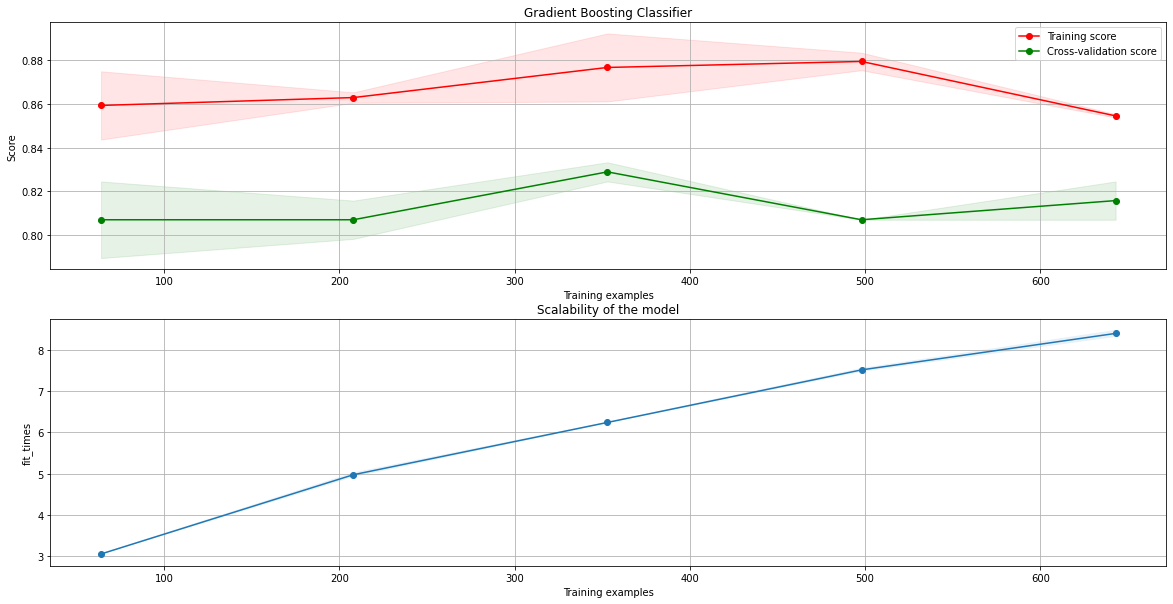

In [33]:
# Building learning curve of model
plot_learning_curve(gradient_boosting_CV, "Gradient Boosting Classifier", train, target, cv=cv_train)

## 3- LGBMClassifier

**Light GBM** is a fast, distributed, high-performance gradient boosting framework based on decision tree algorithms. It splits the tree leaf wise with the best fit whereas other boosting algorithms split the tree depth wise or level wise rather than leaf-wise. So when growing on the same leaf in Light GBM, the leaf-wise algorithm can reduce more loss than the level-wise algorithm and hence results in much better accuracy which can rarely be achieved by any of the existing boosting algorithms. Also, it is surprisingly very fast, hence the word ‘Light’. 
Reference Analytics Vidhya.

In [34]:
#%% split training set to validation set
Xtrain, Xval, Ztrain, Zval = train_test_split(trainb, targetb, test_size=test_train_split_part, random_state=random_state)
modelL = lgb.LGBMClassifier(n_estimators=1000, num_leaves=50)
modelL.fit(Xtrain, Ztrain, eval_set=[(Xval, Zval)], early_stopping_rounds=50, verbose=True)

[1]	valid_0's binary_logloss: 0.625821
[2]	valid_0's binary_logloss: 0.587323
[3]	valid_0's binary_logloss: 0.557915
[4]	valid_0's binary_logloss: 0.533771
[5]	valid_0's binary_logloss: 0.513128
[6]	valid_0's binary_logloss: 0.49818
[7]	valid_0's binary_logloss: 0.484089
[8]	valid_0's binary_logloss: 0.473949
[9]	valid_0's binary_logloss: 0.463204
[10]	valid_0's binary_logloss: 0.459305
[11]	valid_0's binary_logloss: 0.45797
[12]	valid_0's binary_logloss: 0.454897
[13]	valid_0's binary_logloss: 0.454642
[14]	valid_0's binary_logloss: 0.45116
[15]	valid_0's binary_logloss: 0.446548
[16]	valid_0's binary_logloss: 0.445207
[17]	valid_0's binary_logloss: 0.444408
[18]	valid_0's binary_logloss: 0.440806
[19]	valid_0's binary_logloss: 0.439462
[20]	valid_0's binary_logloss: 0.441737
[21]	valid_0's binary_logloss: 0.442018
[22]	valid_0's binary_logloss: 0.438692
[23]	valid_0's binary_logloss: 0.434859
[24]	valid_0's binary_logloss: 0.435397
[25]	valid_0's binary_logloss: 0.4386
[26]	valid_0's

LGBMClassifier(n_estimators=1000, num_leaves=50)

In [35]:
acc_metrics_calc(8,modelL,trainb,testb,targetb,target_testb)

target =  [0 0 0 0 0]
ytrain =  [0 0 0 0 0]
target_test = [0 0 0 1 1]
ytest = [0 0 0 1 1]
acc of r2_score for train = 55.1
acc of r2_score for test = 35.24
acc of acc for train = 89.43
acc of acc for test = 84.33
acc of rmse for train = 32.51
acc of rmse for test = 39.59
acc of re for train = 27.87
acc of re for test = 38.18


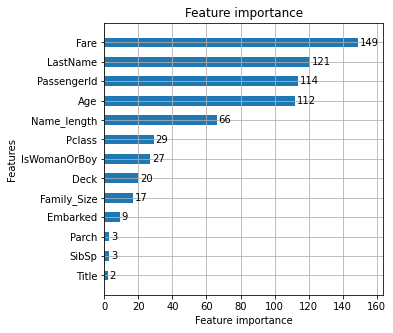

In [36]:
fig =  plt.figure(figsize = (5,5))
axes = fig.add_subplot(111)
lgb.plot_importance(modelL,ax = axes,height = 0.5)
plt.show();
plt.close()

## 4- XGBClassifier

**XGBoost** is an ensemble tree method that apply the principle of boosting weak learners (CARTs generally) using the gradient descent architecture. XGBoost improves upon the base Gradient Boosting Machines (GBM) framework through systems optimization and algorithmic enhancements. 
Reference Towards Data Science.

In [37]:
%%time
# XGBoost Classifier
xgb_clf = xgb.XGBClassifier(objective='reg:squarederror') 
parameters = {'n_estimators': [200, 300, 400], 
              'learning_rate': [0.001, 0.003, 0.005, 0.006, 0.01],
              'max_depth': [4, 5, 6]}
xgb_reg = GridSearchCV(estimator=xgb_clf, param_grid=parameters, cv=cv_train).fit(trainb, targetb)
print("Best score: %0.3f" % xgb_reg.best_score_)
print("Best parameters set:", xgb_reg.best_params_)
acc_metrics_calc(7,xgb_reg,trainb,testb,targetb,target_testb)

Best score: 0.820
Best parameters set: {'learning_rate': 0.005, 'max_depth': 4, 'n_estimators': 400}
target =  [0 0 0 0 0]
ytrain =  [0 0 0 0 0]
target_test = [0 0 0 1 1]
ytest = [0 0 0 1 0]
acc of r2_score for train = 47.81
acc of r2_score for test = 25.98
acc of acc for train = 87.71
acc of acc for test = 82.09
acc of rmse for train = 35.05
acc of rmse for test = 42.32
acc of re for train = 32.4
acc of re for test = 43.64
CPU times: user 5min 39s, sys: 4.16 s, total: 5min 43s
Wall time: 1min 27s


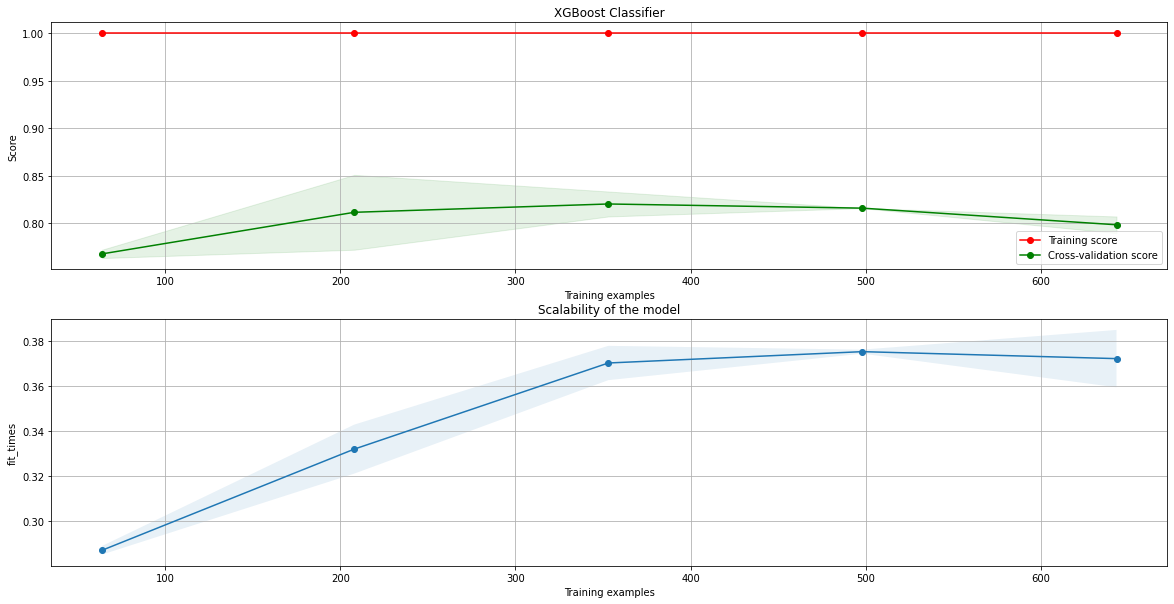

In [38]:
# Building learning curve of model
plot_learning_curve(xgb_clf, "XGBoost Classifier", trainb, targetb, cv=cv_train)

## 5- ExtraTreesClassifier

**ExtraTreesClassifier** implements a meta estimator that fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The default values for the parameters controlling the size of the trees (e.g. max_depth, min_samples_leaf, etc.) lead to fully grown and unpruned trees which can potentially be very large on some data sets. To reduce memory consumption, the complexity and size of the trees should be controlled by setting those parameter values. 
Reference sklearn documentation.

In [39]:
# Extra Trees Classifier

etr = ExtraTreesClassifier()
etr_CV = GridSearchCV(estimator=etr, param_grid={'min_samples_leaf' : [10, 20, 30, 40, 50]}, cv=cv_train, verbose=False)
etr_CV.fit(train, target)
acc_metrics_calc(12,etr_CV,train,test,target,target_test)

target =  [0 0 0 0 0]
ytrain =  [0 0 0 1 0]
target_test = [0 0 0 1 1]
ytest = [0 0 0 1 1]
acc of r2_score for train = 28.73
acc of r2_score for test = 25.98
acc of acc for train = 83.22
acc of acc for test = 82.09
acc of rmse for train = 40.96
acc of rmse for test = 42.32
acc of re for train = 44.25
acc of re for test = 43.64


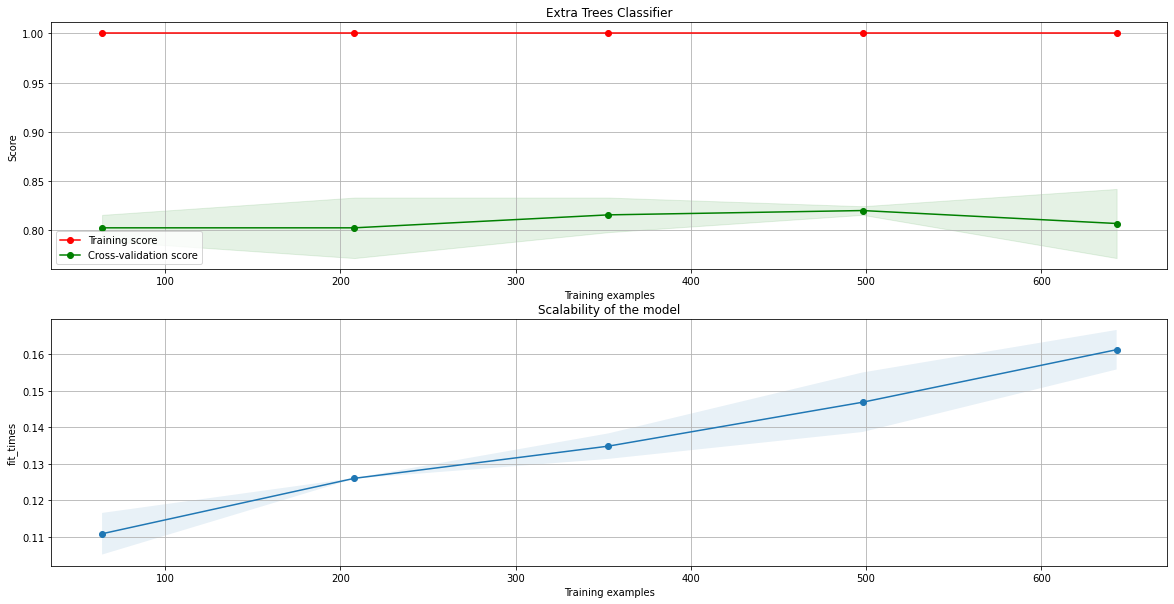

In [40]:
# Building learning curve of model
plot_learning_curve(etr, "Extra Trees Classifier", train, target, cv=cv_train)

## 6- Linear SVC	

**Linear SVC** is a similar to SVM method. Its also builds on kernel functions but is appropriate for unsupervised learning. 
Reference Wikipedia.

In [41]:
# Linear SVR

linear_svc = LinearSVC()
param_grid = {'dual':[False],
              'C': np.linspace(1, 15, 15)}
linear_svc_CV = GridSearchCV(linear_svc, param_grid=param_grid, cv=cv_train, verbose=False)
linear_svc_CV.fit(train, target)
print(linear_svc_CV.best_params_)
acc_metrics_calc(2,linear_svc_CV,train,test,target,target_test)

{'C': 1.0, 'dual': False}
target =  [0 0 0 0 0]
ytrain =  [0 0 0 1 0]
target_test = [0 0 0 1 1]
ytest = [0 0 0 1 1]
acc of r2_score for train = 31.53
acc of r2_score for test = 29.07
acc of acc for train = 83.88
acc of acc for test = 82.84
acc of rmse for train = 40.15
acc of rmse for test = 41.43
acc of re for train = 42.51
acc of re for test = 41.82


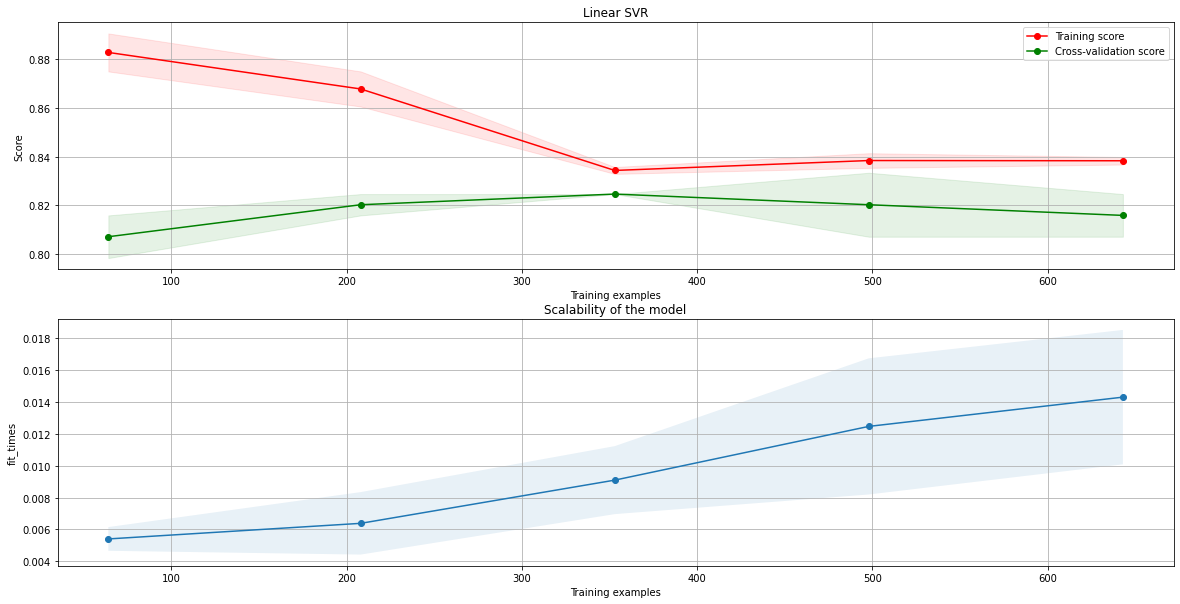

In [42]:
# Building learning curve of model
plot_learning_curve(linear_svc, "Linear SVR", train, target, cv=cv_train)

## 7- Gaussian Process Classification	

**The GaussianProcessClassifier** implements Gaussian processes (GP) for classification purposes, more specifically for probabilistic classification, where test predictions take the form of class probabilities. GaussianProcessClassifier places a GP prior on a latent function, which is then squashed through a link function to obtain the probabilistic classification. The latent function is a so-called nuisance function, whose values are not observed and are not relevant by themselves. Its purpose is to allow a convenient formulation of the model. GaussianProcessClassifier implements the logistic link function, for which the integral cannot be computed analytically but is easily approximated in the binary case.

Reference Sklearn documentation.

In [43]:
# Gaussian Process Classification

gpc = GaussianProcessClassifier()
param_grid = {'max_iter_predict': [100, 200],
              'warm_start': [True, False],
              'n_restarts_optimizer': range(3)}
gpc_CV = GridSearchCV(estimator=gpc, param_grid=param_grid, cv=cv_train, verbose=False)
gpc_CV.fit(train, target)
print(gpc_CV.best_params_)
acc_metrics_calc(18,gpc_CV,train,test,target,target_test)

{'max_iter_predict': 100, 'n_restarts_optimizer': 0, 'warm_start': True}
target =  [0 0 0 0 0]
ytrain =  [0 0 0 1 0]
target_test = [0 0 0 1 1]
ytest = [0 0 0 1 1]
acc of r2_score for train = 32.1
acc of r2_score for test = 25.98
acc of acc for train = 84.02
acc of acc for test = 82.09
acc of rmse for train = 39.98
acc of rmse for test = 42.32
acc of re for train = 42.16
acc of re for test = 43.64


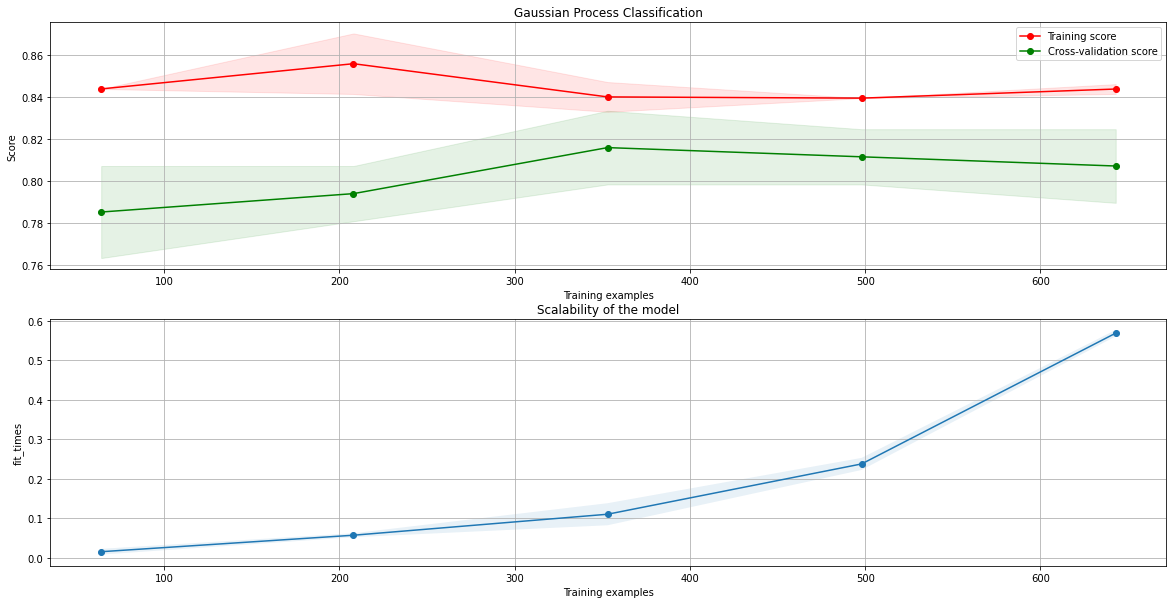

In [44]:
# Building learning curve of model
plot_learning_curve(gpc, "Gaussian Process Classification", train, target, cv=cv_train)

## 8- BaggingClassifier	

Bootstrap aggregating, also called **Bagging**, is a machine learning ensemble meta-algorithm designed to improve the stability and accuracy of machine learning algorithms used in statistical classification and regression. It also reduces variance and helps to avoid overfitting. Although it is usually applied to decision tree methods, it can be used with any type of method. Bagging is a special case of the model averaging approach. Bagging leads to "improvements for unstable procedures", which include, for example, artificial neural networks, classification and regression trees, and subset selection in linear regression. On the other hand, it can mildly degrade the performance of stable methods such as K-nearest neighbors. Reference Wikipedia.

In [45]:
%%time
# Bagging Classifier

bagging = BaggingClassifier(base_estimator=linear_svc_CV)
param_grid={'max_features': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
            'n_estimators': [3, 5, 10],
            'warm_start' : [True],
            'random_state': [random_state]}
bagging_CV = GridSearchCV(estimator=bagging, param_grid=param_grid, cv=cv_train, verbose=False)
bagging_CV.fit(train, target)
print(bagging_CV.best_params_)
acc_metrics_calc(11,bagging_CV,train,test,target,target_test)

{'max_features': 1.0, 'n_estimators': 5, 'random_state': 0, 'warm_start': True}
target =  [0 0 0 0 0]
ytrain =  [0 0 0 1 0]
target_test = [0 0 0 1 1]
ytest = [0 0 0 1 1]
acc of r2_score for train = 32.1
acc of r2_score for test = 25.98
acc of acc for train = 84.02
acc of acc for test = 82.09
acc of rmse for train = 39.98
acc of rmse for test = 42.32
acc of re for train = 42.16
acc of re for test = 43.64
CPU times: user 24.5 s, sys: 131 ms, total: 24.7 s
Wall time: 24.7 s


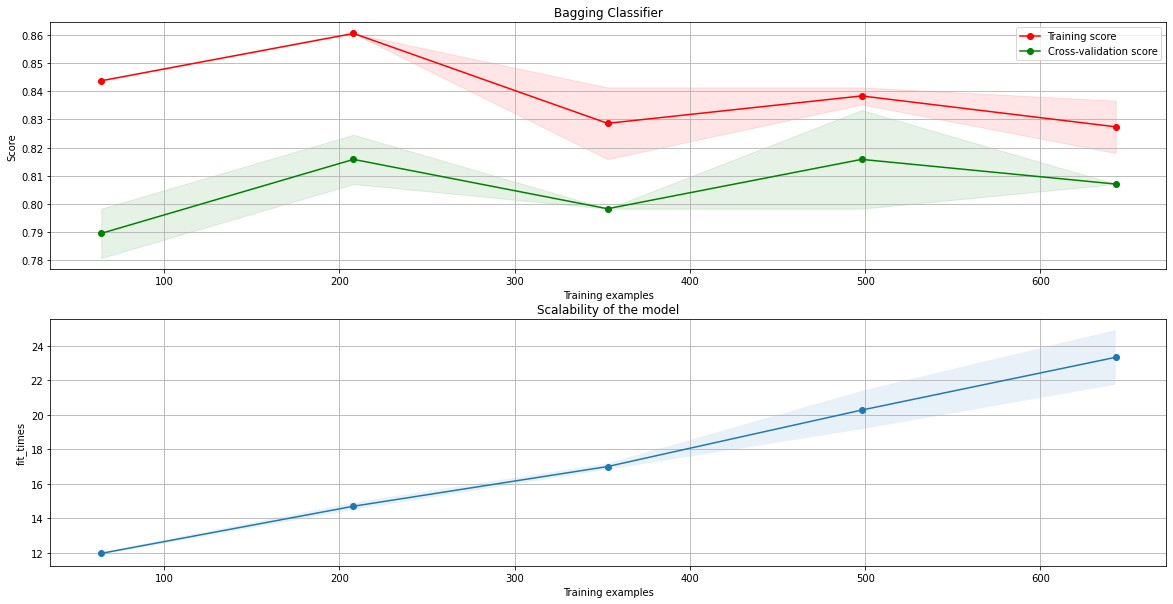

In [46]:
# Building learning curve of model
plot_learning_curve(bagging_CV, "Bagging Classifier", train, target, cv=cv_train)

## 9- Random Forest	

**Random Forest** is one of the most popular model. Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks, that operate by constructing a multitude of decision trees (n_estimators= [100, 300]) at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. Reference Wikipedia.

In [47]:
%%time
# Random Forest
# Parameters of model (param_grid) taken from the notebook https://www.kaggle.com/morenovanton/titanic-random-forest

random_forest = RandomForestClassifier()
param_grid = {'n_estimators': [300, 400, 500, 600], 'min_samples_split': [60], 'min_samples_leaf': [20, 25, 30, 35, 40], 
              'max_features': ['auto'], 'max_depth': [5, 6, 7, 8, 9, 10], 'criterion': ['gini'], 'bootstrap': [False]}
random_forest_CV = GridSearchCV(estimator=random_forest, param_grid=param_grid, 
                             cv=cv_train, verbose=False)
random_forest_CV.fit(train, target)
print(random_forest_CV.best_params_)
acc_metrics_calc(6,random_forest_CV,train,test,target,target_test)

{'bootstrap': False, 'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 20, 'min_samples_split': 60, 'n_estimators': 300}
target =  [0 0 0 0 0]
ytrain =  [0 0 0 1 0]
target_test = [0 0 0 1 1]
ytest = [0 0 0 1 1]
acc of r2_score for train = 31.53
acc of r2_score for test = 32.15
acc of acc for train = 83.88
acc of acc for test = 83.58
acc of rmse for train = 40.15
acc of rmse for test = 40.52
acc of re for train = 42.51
acc of re for test = 40.0
CPU times: user 2min 43s, sys: 927 ms, total: 2min 44s
Wall time: 2min 44s


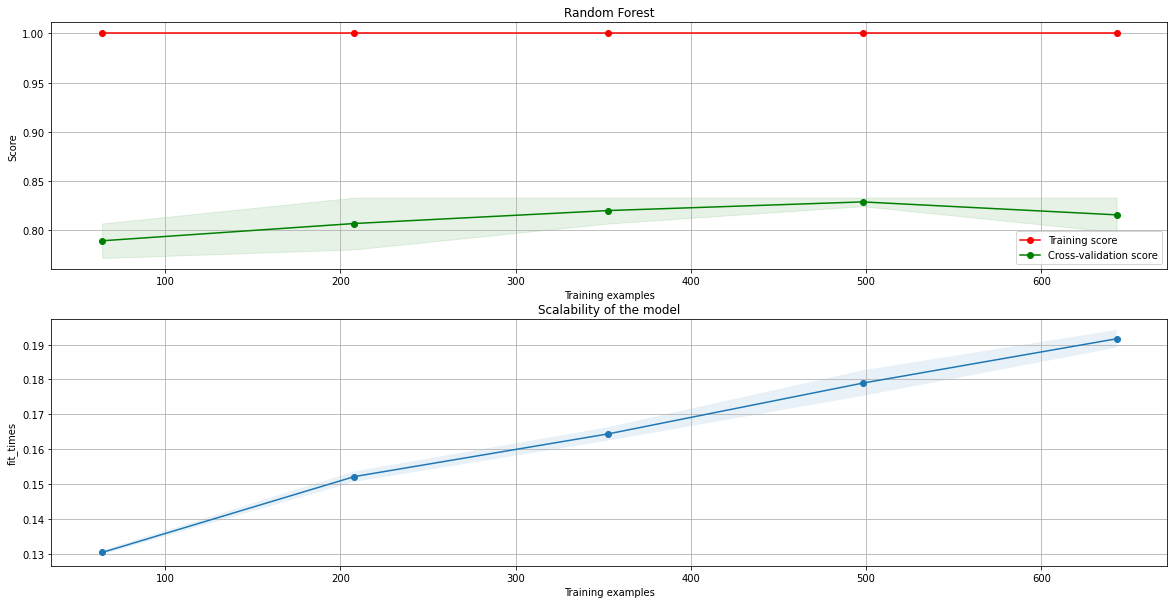

In [48]:
# Building learning curve of model
plot_learning_curve(random_forest, "Random Forest", train, target, cv=cv_train)

## 10- KNN

In pattern recognition, the **k-Nearest Neighbors algorithm** (or k-NN for short) is a non-parametric method used for classification and regression. A sample is classified by a majority vote of its neighbors, with the sample being assigned to the class most common among its k nearest neighbors (k is a positive integer, typically small). Reference Wikipedia.

In [49]:
# KNN - k-Nearest Neighbors algorithm

knn = KNeighborsClassifier()
param_grid={'n_neighbors': range(2, 7)}
knn_CV = GridSearchCV(estimator=knn, param_grid=param_grid, 
                      cv=cv_train, verbose=False).fit(train, target)
print(knn_CV.best_params_)
acc_metrics_calc(15,knn_CV,train,test,target,target_test)

{'n_neighbors': 6}
target =  [0 0 0 0 0]
ytrain =  [0 0 0 1 0]
target_test = [0 0 0 1 1]
ytest = [0 0 0 1 1]
acc of r2_score for train = 38.27
acc of r2_score for test = 25.98
acc of acc for train = 85.47
acc of acc for test = 82.09
acc of rmse for train = 38.12
acc of rmse for test = 42.32
acc of re for train = 38.33
acc of re for test = 43.64


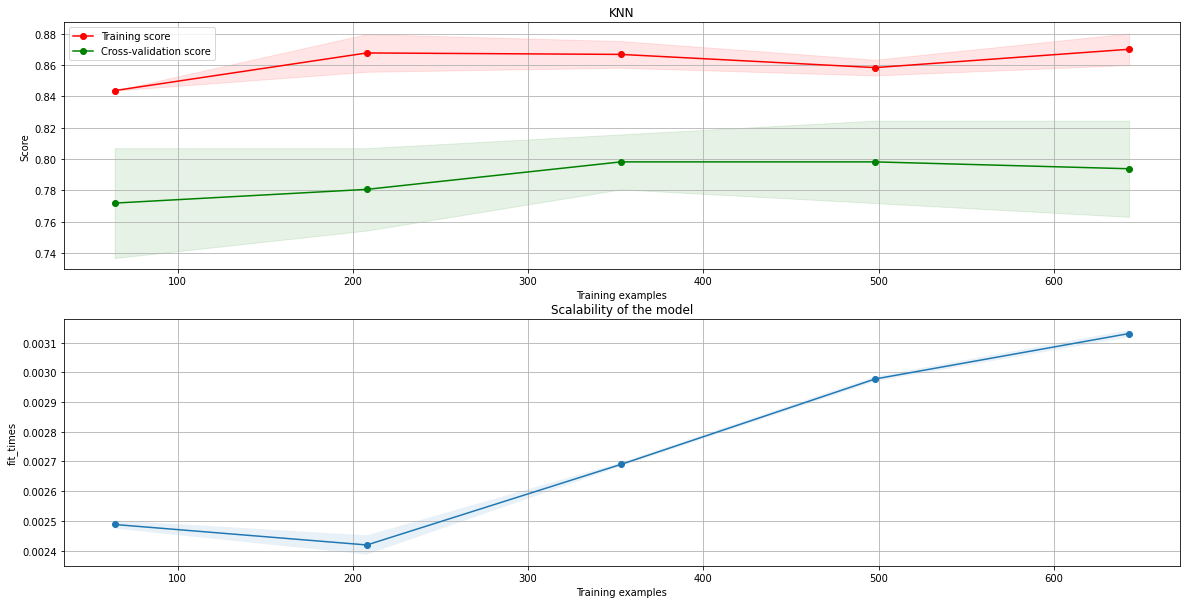

In [50]:
# Building learning curve of model
plot_learning_curve(knn, "KNN", train, target, cv=cv_train)

# Models comparison

In [51]:
models = pd.DataFrame({'Model': [ "Decision Tree Classifier","GradientBoostingClassifier","LGBMClassifier","XGBClassifier","ExtraTreesClassifier","Linear SVC","Gaussian Process Classification","aggingClassifier","Random Forest","KNN"]})

In [52]:
for x in metrics_now:
    xs = metrics_all[x]
    models[xs + '_train'] = acc_all[(x-1)*2]
    models[xs + '_test'] = acc_all[(x-1)*2+1]
    if xs == "acc":
        models[xs + '_diff'] = models[xs + '_train'] - models[xs + '_test']
models

,Model,r2_score_train,r2_score_test,acc_train,acc_test,acc_diff,rmse_train,rmse_test,re_train,re_test
0,Decision Tree Classifier,52.86,25.98,88.90,82.09,6.81,33.31,42.32,29.27,43.64
1,GradientBoostingClassifier,42.20,32.15,86.39,83.58,2.81,36.89,40.52,35.89,40.00
2,LGBMClassifier,55.10,35.24,89.43,84.33,5.10,32.51,39.59,27.87,38.18
3,XGBClassifier,47.81,25.98,87.71,82.09,5.62,35.05,42.32,32.40,43.64
4,ExtraTreesClassifier,28.73,25.98,83.22,82.09,1.13,40.96,42.32,44.25,43.64
5,Linear SVC,31.53,29.07,83.88,82.84,1.04,40.15,41.43,42.51,41.82
6,Gaussian Process Classification,32.10,25.98,84.02,82.09,1.93,39.98,42.32,42.16,43.64
7,aggingClassifier,32.10,25.98,84.02,82.09,1.93,39.98,42.32,42.16,43.64
8,Random Forest,31.53,32.15,83.88,83.58,0.30,40.15,40.52,42.51,40.00
9,KNN,38.27,25.98,85.47,82.09,3.38,38.12,42.32,38.33,43.64


In [53]:
print('Prediction accuracy for models')
ms = metrics_all[metrics_now[1]] # the accuracy
models.sort_values(by=[(ms + '_test'), (ms + '_train')], ascending=False)

Prediction accuracy for models


,Model,r2_score_train,r2_score_test,acc_train,acc_test,acc_diff,rmse_train,rmse_test,re_train,re_test
2,LGBMClassifier,55.10,35.24,89.43,84.33,5.10,32.51,39.59,27.87,38.18
1,GradientBoostingClassifier,42.20,32.15,86.39,83.58,2.81,36.89,40.52,35.89,40.00
8,Random Forest,31.53,32.15,83.88,83.58,0.30,40.15,40.52,42.51,40.00
5,Linear SVC,31.53,29.07,83.88,82.84,1.04,40.15,41.43,42.51,41.82
0,Decision Tree Classifier,52.86,25.98,88.90,82.09,6.81,33.31,42.32,29.27,43.64
3,XGBClassifier,47.81,25.98,87.71,82.09,5.62,35.05,42.32,32.40,43.64
9,KNN,38.27,25.98,85.47,82.09,3.38,38.12,42.32,38.33,43.64
6,Gaussian Process Classification,32.10,25.98,84.02,82.09,1.93,39.98,42.32,42.16,43.64
7,aggingClassifier,32.10,25.98,84.02,82.09,1.93,39.98,42.32,42.16,43.64
4,ExtraTreesClassifier,28.73,25.98,83.22,82.09,1.13,40.96,42.32,44.25,43.64


In [54]:
pd.options.display.float_format = '{:,.2f}'.format

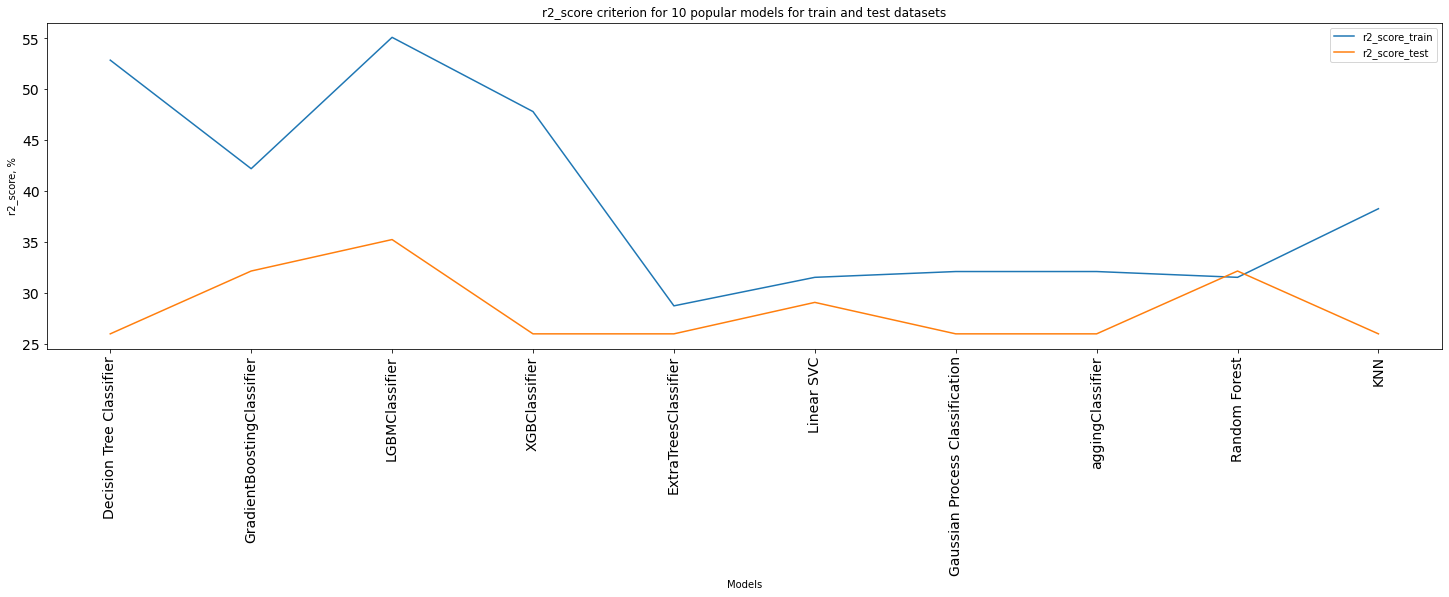

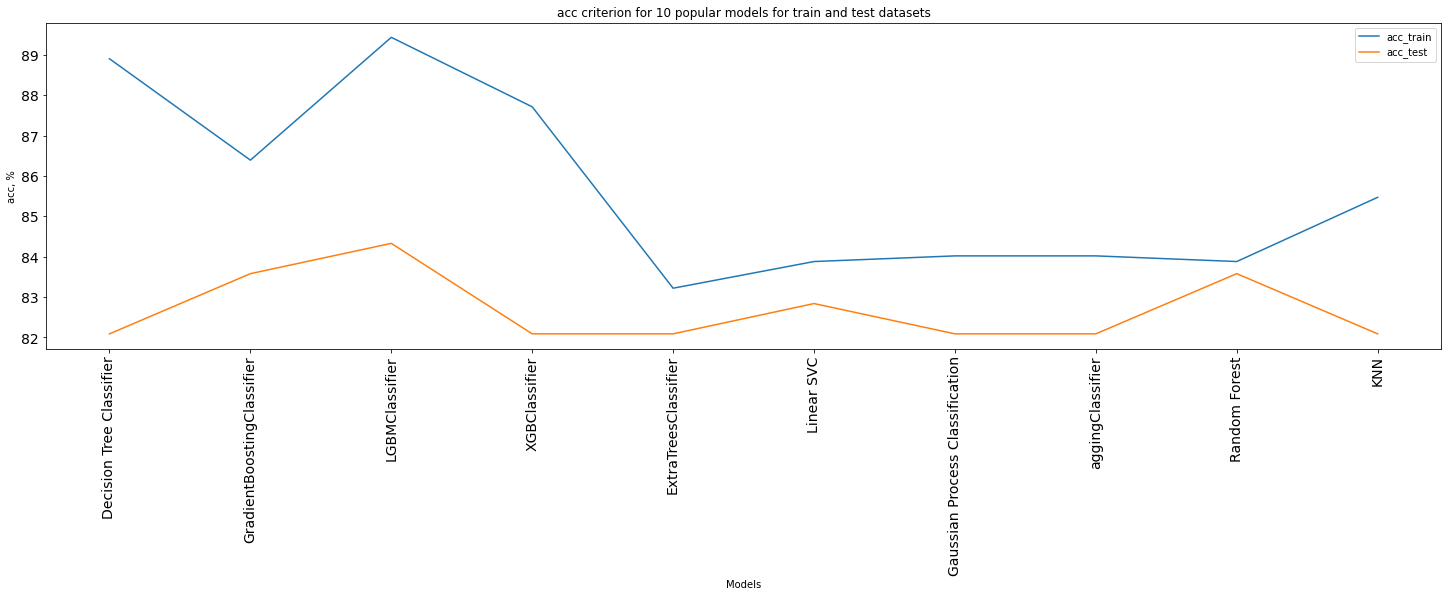

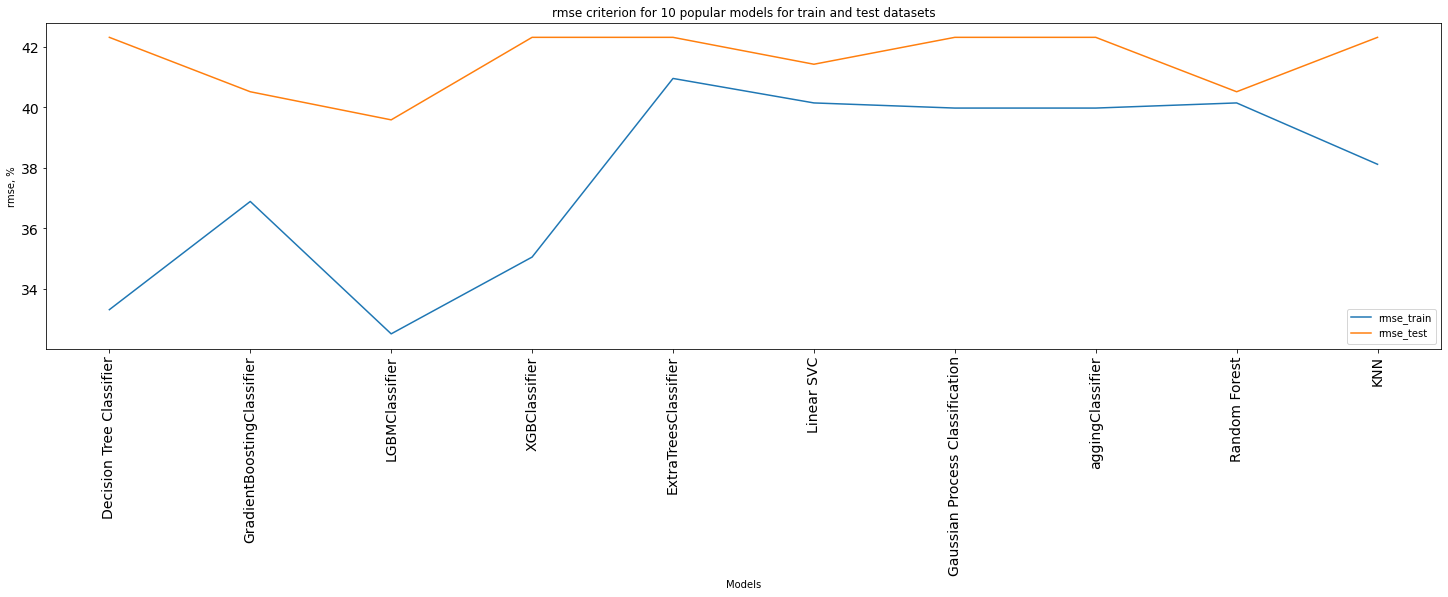

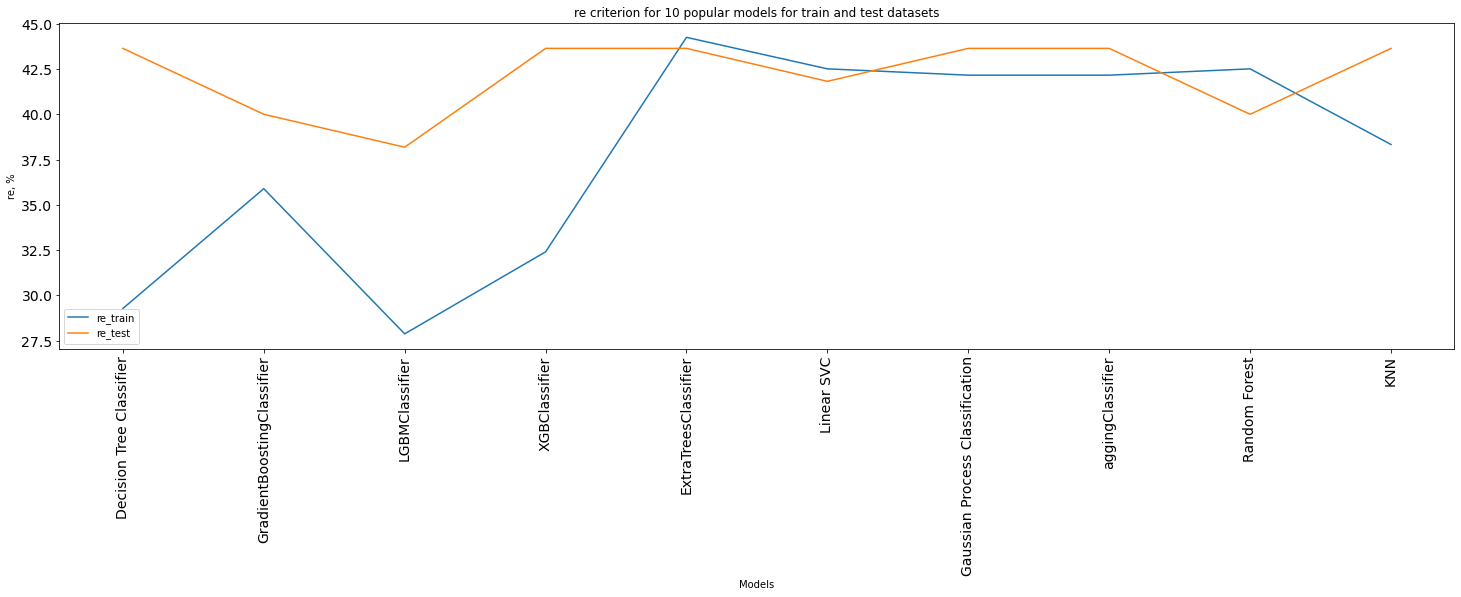

In [55]:
for x in metrics_now:   
    # Plot
    xs = metrics_all[x]
    xs_train = metrics_all[x] + '_train'
    xs_test = metrics_all[x] + '_test'
    plt.figure(figsize=[25,6])
    xx = models['Model']
    plt.tick_params(labelsize=14)
    plt.plot(xx, models[xs_train], label = xs_train)
    plt.plot(xx, models[xs_test], label = xs_test)
    plt.legend()
    plt.title(str(xs) + ' criterion for ' + str(num_models) + ' popular models for train and test datasets')
    plt.xlabel('Models')
    plt.ylabel(xs + ', %')
    plt.xticks(xx, rotation='vertical')
    plt.show()

In [56]:
# Choose the number of metric by which the best models will be determined =>  {1 : 'r2_score', 2 : 'relative_error', 3 : 'rmse'}
metrics_main = 2
xs = metrics_all[metrics_main]
xs_train = metrics_all[metrics_main] + '_train'
xs_test = metrics_all[metrics_main] + '_test'
print('The best models by the',xs,'criterion:')
direct_sort = False if (metrics_main >= 2) else True
models_sort = models.sort_values(by=[xs_test, xs_train], ascending=direct_sort)
models_sort

The best models by the acc criterion:


,Model,r2_score_train,r2_score_test,acc_train,acc_test,acc_diff,rmse_train,rmse_test,re_train,re_test
2,LGBMClassifier,55.10,35.24,89.43,84.33,5.10,32.51,39.59,27.87,38.18
1,GradientBoostingClassifier,42.20,32.15,86.39,83.58,2.81,36.89,40.52,35.89,40.00
8,Random Forest,31.53,32.15,83.88,83.58,0.30,40.15,40.52,42.51,40.00
5,Linear SVC,31.53,29.07,83.88,82.84,1.04,40.15,41.43,42.51,41.82
0,Decision Tree Classifier,52.86,25.98,88.90,82.09,6.81,33.31,42.32,29.27,43.64
3,XGBClassifier,47.81,25.98,87.71,82.09,5.62,35.05,42.32,32.40,43.64
9,KNN,38.27,25.98,85.47,82.09,3.38,38.12,42.32,38.33,43.64
6,Gaussian Process Classification,32.10,25.98,84.02,82.09,1.93,39.98,42.32,42.16,43.64
7,aggingClassifier,32.10,25.98,84.02,82.09,1.93,39.98,42.32,42.16,43.64
4,ExtraTreesClassifier,28.73,25.98,83.22,82.09,1.13,40.96,42.32,44.25,43.64


In [57]:
# Selection the best models except VotingClassifier
models_sort = models_sort[models_sort.Model != 'VotingClassifier']
models_best = models_sort[(models_sort.acc_diff < 10) & (models_sort.acc_train > 70)]
models_best[['Model', ms + '_train', ms + '_test', 'acc_diff']].sort_values(by=['acc_test'], ascending=False)

,Model,acc_train,acc_test,acc_diff
2,LGBMClassifier,89.43,84.33,5.10
1,GradientBoostingClassifier,86.39,83.58,2.81
8,Random Forest,83.88,83.58,0.30
5,Linear SVC,83.88,82.84,1.04
0,Decision Tree Classifier,88.90,82.09,6.81
3,XGBClassifier,87.71,82.09,5.62
9,KNN,85.47,82.09,3.38
6,Gaussian Process Classification,84.02,82.09,1.93
7,aggingClassifier,84.02,82.09,1.93
4,ExtraTreesClassifier,83.22,82.09,1.13


## Prediction

In [58]:
models_pred = pd.DataFrame(models_best.Model, columns = ['Model'])
N_best_models = len(models_best.Model)

In [59]:
def model_fit(name_model,train,target):
    # Fitting name_model (from 20 options) for giver train and target
    # You can optionally add hyperparameters optimization in any model
    if name_model == 'LGBMClassifier':
        Xtrain, Xval, Ztrain, Zval = train_test_split(train, target, test_size=test_train_split_part, random_state=random_state)
        model = lgb.LGBMClassifier(n_estimators=1000)
        model.fit(Xtrain, Ztrain, eval_set=[(Xval, Zval)], early_stopping_rounds=50, verbose=False)
                
    else:
        param_grid={}
        
        if name_model == 'Linear Regression':
            model_clf = LinearRegression()
            
        elif name_model == 'Support Vector Machines':
            model_clf = SVC()
            param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'tol': [1e-4]}
            
        elif name_model == 'Linear SVC':
            model_clf = LinearSVC()
            param_grid = {'dual':[False],
                          'C': np.linspace(1, 15, 15)}
            
        elif name_model == 'MLPClassifier':
            model_clf = MLPClassifier()
            param_grid = {'hidden_layer_sizes': [i for i in range(2,5)],
                          'solver': ['sgd'],
                          'learning_rate': ['adaptive'],
                          'max_iter': [1000]
                          }

        elif name_model == 'Stochastic Gradient Decent':
            model_clf = SGDClassifier(early_stopping=True)
            param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1]}

        elif name_model == 'Decision Tree Classifier':
            model_clf = DecisionTreeClassifier()
            param_grid = {'min_samples_leaf': [i for i in range(2,10)]}

        elif name_model == 'Random Forest':
            model_clf = RandomForestClassifier()
            param_grid = {'n_estimators': [300, 400, 500, 600], 'min_samples_split': [60], 'min_samples_leaf': [20, 25, 30, 35, 40], 
                          'max_features': ['auto'], 'max_depth': [5, 6, 7, 8, 9, 10], 'criterion': ['gini'], 'bootstrap': [False]}

        elif name_model == 'XGBClassifier':
            model_clf = xgb.XGBClassifier(objective='reg:squarederror') 
            param_grid = {'n_estimators': [200, 300, 400], 
                          'learning_rate': [0.001, 0.003, 0.005, 0.006, 0.01],
                          'max_depth': [4, 5, 6]}
                        
        elif name_model == 'GradientBoostingClassifier':
            model_clf = GradientBoostingClassifier()
            param_grid = {'learning_rate' : [0.001, 0.01, 0.1],
                          'max_depth': [i for i in range(2,5)],
                          'min_samples_leaf': [i for i in range(2,5)]}

        elif name_model == 'RidgeClassifier':
            model_clf = RidgeClassifier()
            param_grid={'alpha': np.linspace(.1, 1.5, 15)}

        elif name_model == 'BaggingClassifier':
            model_base_estimator = GridSearchCV(LinearSVC(), param_grid={'dual':[False], 'C': np.linspace(1, 15, 15)}, 
                                            cv=cv_train, verbose=False)
            model_base_estimator.fit(train, target)
            model_clf = BaggingClassifier(base_estimator=model_base_estimator)
            param_grid={'max_features': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                        'n_estimators': [3, 5, 10],
                        'warm_start' : [True],
                        'random_state': [random_state]}

        elif name_model == 'ExtraTreesClassifier':
            model_clf = ExtraTreesClassifier()
            param_grid={'min_samples_leaf' : [10, 20, 30, 40, 50]}

        elif name_model == 'AdaBoostClassifier':
            model_clf = AdaBoostClassifier()
            param_grid={'learning_rate' : [.01, .1, .5, 1]}

        elif name_model == 'Logistic Regression':
            model_clf = LogisticRegression()
            param_grid={'C' : [.1, .3, .5, .7, 1]}

        elif name_model == 'KNN':
            model_clf = KNeighborsClassifier()
            param_grid={'n_neighbors': range(2, 7)}

        elif name_model == 'Naive Bayes':
            model_clf = GaussianNB()
            param_grid={'var_smoothing': [1e-8, 1e-9, 1e-10]}

        elif name_model == 'Perceptron':
            model_clf = Perceptron()
            param_grid = {'penalty': [None, 'l2', 'l1', 'elasticnet']}
            
        elif name_model == 'Gaussian Process Classification':
            model_clf = GaussianProcessClassifier()
            param_grid = {'max_iter_predict': [100, 200],
                          'warm_start': [True, False],
                          'n_restarts_optimizer': range(3)}
            
        model = GridSearchCV(model_clf, param_grid=param_grid, cv=cv_train, verbose=False)
        model.fit(train, target)
        
    return model

In [60]:
for i in range(N_best_models):
    name_model = models_best.iloc[i]['Model']
    if (name_model == 'LGBMClassifier') or (name_model == 'XGBClassifier'):
        # lgboosting model
        model = model_fit(name_model,train0b,target0)
        acc_metrics_calc_pred(i,model,name_model,train0b,test0b,target0)

**********
LGBMClassifier
target =  [0 1 1 1 0 0 0 0 1 1 1 1 0 0 0]
ytrain =  [0 1 1 1 0 0 0 0 1 1 1 1 0 0 1]
ytest = [0 1 0 0 0 0 1 0 1 0 0 0 1 0 1]
acc of r2_score for train = 59.19
acc of acc for train = 90.35
acc of rmse for train = 31.07
acc of re for train = 25.15
**********
XGBClassifier
target =  [0 1 1 1 0 0 0 0 1 1 1 1 0 0 0]
ytrain =  [0 1 1 1 0 0 0 0 1 1 1 1 0 0 0]
ytest = [0 0 0 0 0 0 1 0 1 0 0 0 1 0 1]
acc of r2_score for train = 75.8
acc of acc for train = 94.28
acc of rmse for train = 23.92
acc of re for train = 14.91


# Deep learning : ANN

An artificial neuron network (ANN) is a computational model based on the structure and functions of biological neural networks. Information that flows through the network affects the structure of the ANN because a neural network changes - or learns, in a sense - based on that input and output. ANNs are considered nonlinear statistical data modeling tools where the complex relationships between inputs and outputs are modeled or patterns are found. ANN is also known as a neural network.

A single neuron is known as a perceptron. It consists of a layer of inputs(corresponds to columns of a dataframe). Each input has a weight which controls the magnitude of an input. The summation of the products of these input values and weights is fed to the activation function. Activation functions are really important for a Artificial Neural Network to learn and make sense of something really complicated and Non-linear complex functional mappings between the inputs and response variable.

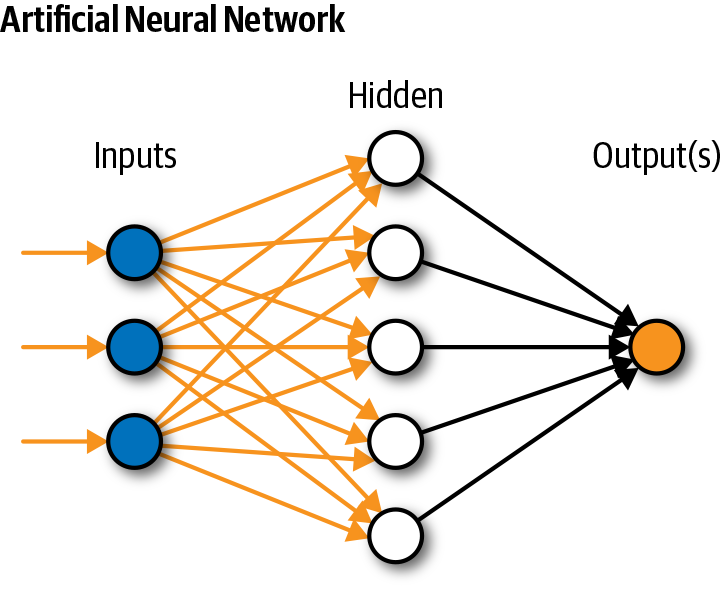

DL based on m notebook https://www.kaggle.com/code/mohamedkhaledelsafty/breast-cancer-prediction-using-ann

In [61]:
#importing keras
import keras
#importing sequential module
from keras.models import Sequential
# import dense module for hidden layers
from keras.layers import Dense
#importing activation functions
from keras.layers import LeakyReLU,PReLU,ELU
from keras.layers import Dropout


train, test, target, target_test = train_test_split(train0, target0, test_size=test_train_split_part, random_state=random_state)
xtrain=train
xtest=test
ytrain=target
ytest=target_test

## Creating Layers
After importing those libraries, we create the three types of layers:

- Input layer
- Hidden layer
- Output layer

In [62]:
#CREATING THE ANN AS SEQUENCE OF LAYERS
ann =Sequential()

#ADDING FIRST HIDDEN LAYER WITH 30 NEURONS, THE INPUT LAYER WILL BE ADDED AUTOMATICALLY,
ann.add(Dense(units = 30,activation = 'relu'))
ann.add(Dropout(0.5))

#ADDING 2ND HIDDEN LAYER WITH 30 NEURONS
ann.add(Dense(units = 30,activation = 'relu'))
ann.add(Dropout(0.5))

#ADDING OUTPUT LAYER WITH 1 NEURON , AS THIS IS A BINARY CLASSIFICATION
ann.add(Dense(units = 1,activation = 'sigmoid'))

2022-10-14 18:40:32.455044: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Compiling and Fitting
Optimizer is chosen as adam for gradient descent.

Binary_crossentropy is the loss function used.

We use sigmoid function in output layer

Sigmoid function is used when dealing with classfication problems with 2 types of results.(Submax function is used for 3 or more classification results)

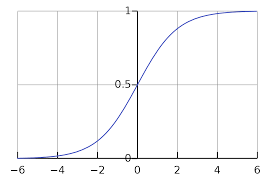

In [63]:
#COMPILING THE ANN USING STOCHASTIC GRADIENT DESCENT (optimizer = 'adam')
ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

#setting callbacks for monitoring maximum accuracy
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

#TRAINING THE ANN WITH BATCH SIZE OF 32 (THIS IS A BATCH LEARNING)
model=ann.fit(xtrain, ytrain,batch_size = 32, epochs =100,callbacks = [early_stop])

2022-10-14 18:40:33.294107: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
24/24 [==============================] - 1s 2ms/step - loss: 0.6789 - accuracy: 0.5918
Epoch 2/100
24/24 [==============================] - 0s 2ms/step - loss: 0.6316 - accuracy: 0.6460
Epoch 3/100
24/24 [==============================] - 0s 2ms/step - loss: 0.6188 - accuracy: 0.6671
Epoch 4/100
24/24 [==============================] - 0s 2ms/step - loss: 0.5864 - accuracy: 0.7199
Epoch 5/100
24/24 [==============================] - 0s 2ms/step - loss: 0.5920 - accuracy: 0.6909
Epoch 6/100
24/24 [==============================] - 0s 2ms/step - loss: 0.5547 - accuracy: 0.7226
Epoch 7/100
24/24 [==============================] - 0s 2ms/step - loss: 0.5621 - accuracy: 0.7318
Epoch 8/100
24/24 [==============================] - 0s 2ms/step - loss: 0.5392 - accuracy: 0.7450
Epoch 9/100
24/24 [==============================] - 0s 2ms/step - loss: 0.5228 - accuracy: 0.7622
Epoch 10/100
24/24 [==============================] - 0s 2ms/step - loss: 0.5103 - accuracy: 0.7622
Epoch 11/

Let us see summary of our model

In [64]:
#taking summary of layers
ann.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                480       
_________________________________________________________________
dropout (Dropout)            (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
Total params: 1,441
Trainable params: 1,441
Non-trainable params: 0
_________________________________________________________________


<AxesSubplot:>

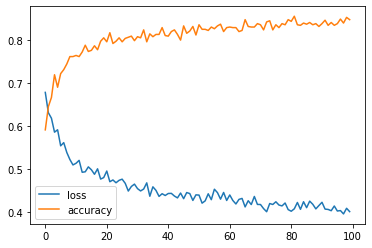

In [65]:
losses = pd.DataFrame(ann.history.history)
losses.plot()

In [66]:
#now testing for Test data
y_pred = ann.predict(xtest)
#converting values
y_pred = (y_pred>0.5)

In [67]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
cm = confusion_matrix(ytest,y_pred)
score = accuracy_score(ytest,y_pred)
print(cm)
print('score is:',score)

[[71  8]
 [13 42]]
score is: 0.8432835820895522


In [68]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(ytest,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87        79
           1       0.84      0.76      0.80        55

    accuracy                           0.84       134
   macro avg       0.84      0.83      0.84       134
weighted avg       0.84      0.84      0.84       134



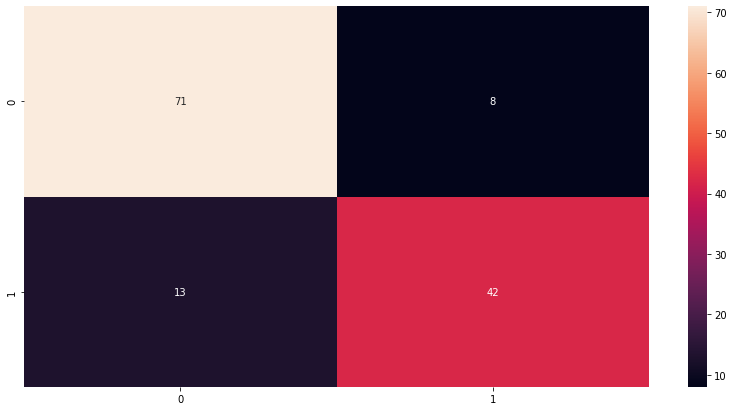

In [69]:
import seaborn as sns
# creating heatmap of comfussion matrix
plt.figure(figsize=[14,7])
sns.heatmap(cm,annot=True)
plt.show()

## ANN Visualizer

In [70]:
!pip install keras
!pip install ann_visualizer
!pip install graphviz

  Preparing metadata (setup.py) ... - done
  Created wheel for ann_visualizer: filename=ann_visualizer-2.5-py3-none-any.whl size=4168 sha256=01dd4e4c39b8fb78017e1ffa5292f656afb9895804a359506191b6b12dc561a8
  Stored in directory: /root/.cache/pip/wheels/1b/fc/58/2ab1c3b30350105929308becddda4fb59b1358e54f985e1f4a
Successfully built ann_visualizer


Error: no "view" mailcap rules found for type "application/pdf"
Error: no "view" mailcap rules found for type "application/pdf"
/usr/bin/xdg-open: 869: www-browser: not found
/usr/bin/xdg-open: 869: www-browser: not found
/usr/bin/xdg-open: 869: links2: not found
/usr/bin/xdg-open: 869: links2: not found
/usr/bin/xdg-open: 869: elinks: not found
/usr/bin/xdg-open: 869: elinks: not found
/usr/bin/xdg-open: 869: links: not found
/usr/bin/xdg-open: 869: links: not found
/usr/bin/xdg-open: 869: lynx: not found
/usr/bin/xdg-open: 869: lynx: not found
/usr/bin/xdg-open: 869: w3m: not found
xdg-open: no method available for opening 'network.gv.pdf'
/usr/bin/xdg-open: 869: w3m: not found
xdg-open: no method available for opening 'network.gv.pdf'
Error: no "view" mailcap rules found for type "application/pdf"
/usr/bin/xdg-open: 869: www-browser: not found
/usr/bin/xdg-open: 869: links2: not found
/usr/bin/xdg-open: 869: elinks: not found
/usr/bin/xdg-open: 869: links: not found
/usr/bin/xdg-ope

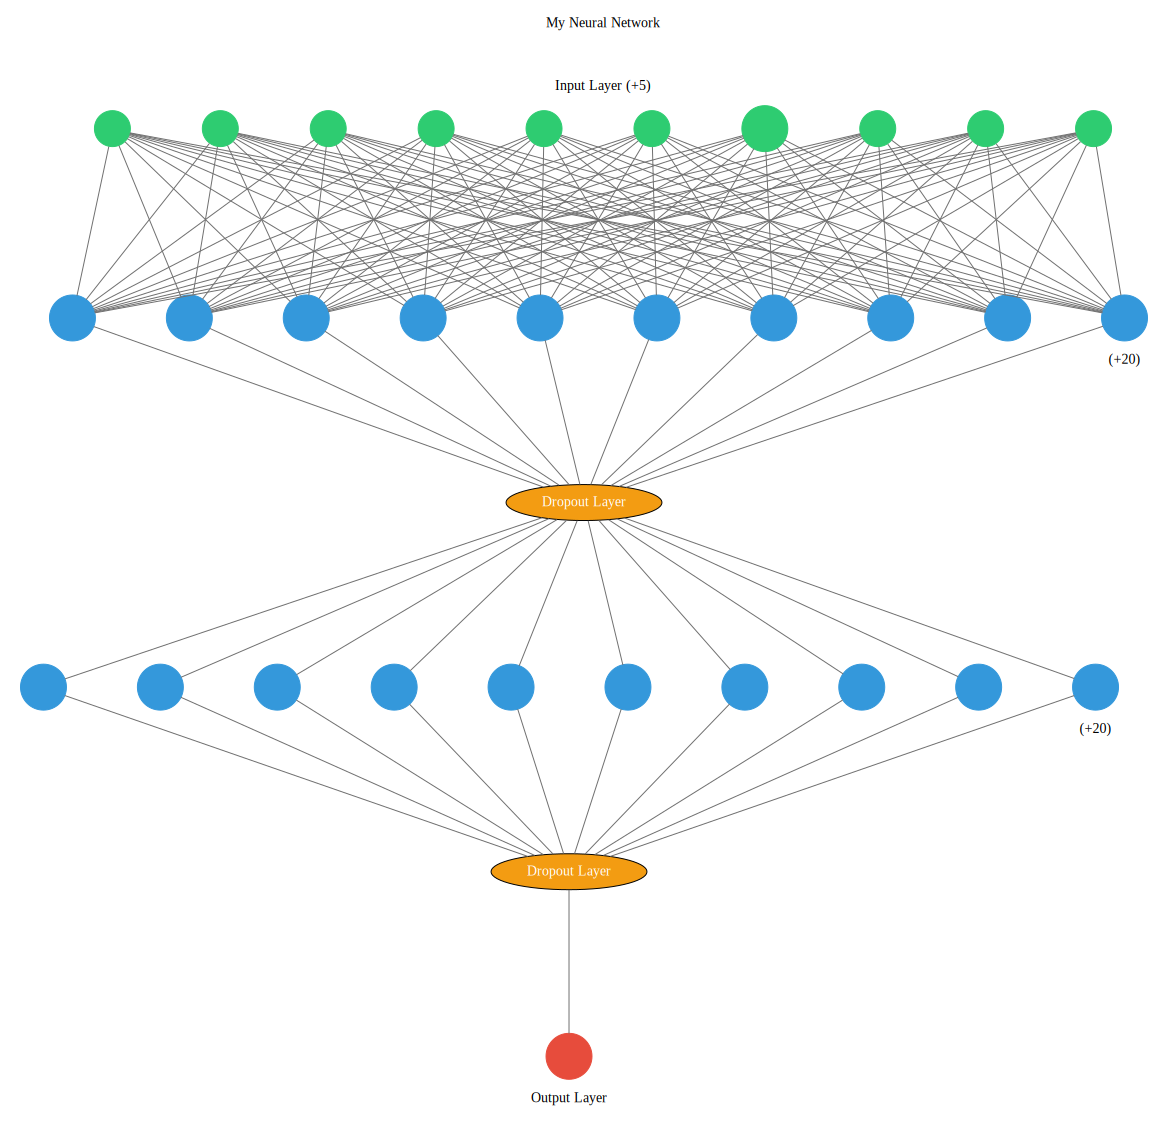

Error: no "view" mailcap rules found for type "application/pdf"
/usr/bin/xdg-open: 869: www-browser: not found
/usr/bin/xdg-open: 869: links2: not found


In [71]:
from ann_visualizer.visualize import ann_viz;
from graphviz import Source
ann_viz(ann, view=True, filename='network.gv', title='My Neural Network')
Source.from_file('./network.gv')

### I hope you find this kernel useful and enjoyable.

### Your comments and feedback are most welcome.